<a href="https://colab.research.google.com/github/dla9944/myPyCode/blob/main/Regressior_GoDaddy_Microbusiness_Density_Forecasting_Rules_test%EC%A0%84%EC%97%90_%EC%A2%85%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 호출

# 기초
import numpy as np
import pandas as pd
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from plotly import express as px

# 사이킷런 분류
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


# 스케일링
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler


# 지도학습

# 회귀 종류
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb


# 분류 종류
import xgboost as xgb # 추후 변경
import lightgbm as lgb # 추후 변경'
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree


# 비지도학습
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 평가용
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 목표

In [ ]:
# 목표 설정

# 북미의 지역구 별 초소형 기업의 밀도 분석
# 타겟(종속변수) : microbuisiness_density
# 피쳐 : 밀도를 계산하기 위한 독립변수인데, 먼저 cifps는 소도시 별 "코드"를 뜻합니다.
# 이 소도시들은 5가지 변수의 영향을 받습니다. 5가지의 의미는 아래와 같습니다.

# 변수 설명

In [ ]:
# pct_bb : 도시의 인터넷 가입자 비율 (2017~2021)
# pc_college : 4년제 대학생 졸업자 비율(25세 이상, 2017~2021)
# pct_foreign_born : 외국인 비율(2017~2021)
# pct_it_workers : IT 종사자 인구비율(2017~2021)
# median_hh_inc : 1년간의 가계 소득 중앙값

# 알고리즘 선정

종속변수는 특정한 밀도이기 때문에, 
사용 알고리즘은 간단하게 linear regression과 knn최근접, lightGBM을 사용해보겠습니다.

가계소득으로 인해 데이터가 금액 vs 그외 비율이 되었기 때문에 스케일링을 진행합니다. (표준 스케일링)

교차검증은 시간상 RandomsearchCV를 사용합니다.


In [ ]:
# from google.colab import files # 파일 업로드
# files.upload() # 4개 파일을 colab에서 업로드함

In [ ]:
# 학습시킬 파일 로드부터 시작
train = pd.read_csv('train.csv') # 훈련용 데이터
census = pd.read_csv('census_starter.csv') # 독립변수에 대한 설명
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


In [ ]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [ ]:
census.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [ ]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non-null   float64
 3   pct_bb_2020            3141 non-null   float64
 4   pct_bb_2021            3141 non-null   float64
 5   cfips                  3142 non-null   int64  
 6   pct_college_2017       3142 non-null   float64
 7   pct_college_2018       3142 non-null   float64
 8   pct_college_2019       3142 non-null   float64
 9   pct_college_2020       3141 non-null   float64
 10  pct_college_2021       3141 non-null   float64
 11  pct_foreign_born_2017  3142 non-null   float64
 12  pct_foreign_born_2018  3142 non-null   float64
 13  pct_foreign_born_2019  3142 non-null   float64
 14  pct_foreign_born_2020  3141 non-null   float64
 15  pct_

In [ ]:
train.info()
# train은 cfips가 x년x월별로 구분, census는 cfips가 연도 구분없이 존재함
# trian의 cfips를 총 기간동안 데이터의 평균으로 groupby할 것인지 vs 가장 최근 날짜의 데이터만 남길것인지

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [ ]:
census.describe(include='all') # 가장 최근의 통계치가 영향이 있을 것이라고 판단하여 cfips는 가장 최근 날짜의 데이터로 남기도록 함
# 그러나 그 자체만으로 의미도 있을 것

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
count,3142.000000,3142.000000,3142.000000,3141.000000,3141.000000,3142.000000,3142.000000,3142.000000,3142.000000,3141.000000,...,3142.000000,3141.000000,3142.000000,3141.000000,3141.000000,3142.000000,3141.000000,3142.000000,3140.000000,3140.000000
mean,69.920401,72.690866,75.398600,78.543298,80.539096,30383.649268,13.813399,14.005379,14.240452,14.631328,...,1.427148,1.382171,1.338956,1.309265,1.272684,49754.163908,51583.175422,53475.909612,55012.443312,58223.339490
std,9.702052,9.255863,8.846665,8.250864,7.889931,15162.508374,5.586649,5.630199,5.689780,5.776940,...,0.986985,0.942777,0.940891,0.990342,0.968579,13154.424871,13703.502202,14192.529173,14649.568591,15541.038914
min,24.500000,25.700000,34.800000,33.300000,37.000000,1001.000000,2.400000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,19264.000000,20188.000000,21504.000000,22292.000000,17109.000000
25%,64.200000,67.425000,70.500000,74.100000,76.400000,18177.500000,9.700000,9.900000,10.100000,10.500000,...,0.800000,0.800000,0.700000,0.700000,0.600000,41123.000000,42480.000000,44155.000000,45653.000000,48179.500000
50%,70.700000,73.600000,76.450000,79.600000,81.700000,29176.000000,12.800000,13.000000,13.250000,13.600000,...,1.300000,1.300000,1.200000,1.200000,1.100000,48065.500000,49888.000000,51757.500000,52842.000000,55907.000000
75%,76.400000,78.800000,81.400000,84.100000,85.900000,45080.500000,16.800000,17.100000,17.300000,17.900000,...,1.900000,1.800000,1.800000,1.800000,1.700000,55763.500000,57611.000000,59867.250000,61500.750000,64930.000000
max,94.600000,95.500000,96.000000,97.100000,97.600000,56045.000000,43.700000,48.000000,45.400000,43.000000,...,17.400000,11.700000,10.500000,15.200000,15.200000,129588.000000,136268.000000,142299.000000,147111.000000,156821.000000


In [ ]:
# 결측치부터 확인
census.isnull().sum().sort_values(ascending=True)

pct_bb_2017              0
median_hh_inc_2019       0
median_hh_inc_2017       0
pct_it_workers_2019      0
pct_it_workers_2017      0
pct_foreign_born_2019    0
pct_foreign_born_2017    0
pct_college_2019         0
pct_foreign_born_2018    0
pct_bb_2018              0
pct_college_2017         0
cfips                    0
pct_bb_2019              0
pct_college_2018         0
pct_college_2020         1
median_hh_inc_2018       1
pct_it_workers_2021      1
pct_it_workers_2020      1
pct_it_workers_2018      1
pct_bb_2021              1
pct_foreign_born_2021    1
pct_foreign_born_2020    1
pct_college_2021         1
pct_bb_2020              1
median_hh_inc_2020       2
median_hh_inc_2021       2
dtype: int64

In [ ]:
train.isnull().mean() # 결측치 없음

row_id                   0.0
cfips                    0.0
county                   0.0
state                    0.0
first_day_of_month       0.0
microbusiness_density    0.0
active                   0.0
dtype: float64

In [ ]:
# 결측치 총합
census.pct_bb_2020.isnull()
census.pct_bb_2021.isnull()
census.pct_college_2020.isnull()
census.pct_college_2021.isnull()
census.pct_foreign_born_2020.isnull()
census.pct_foreign_born_2021.isnull()
census.pct_it_workers_2018.isnull()
census.pct_it_workers_2020.isnull()
census.pct_it_workers_2021.isnull()
census.median_hh_inc_2020.isnull()
census.median_hh_inc_2021.isnull()
# 갯수가 모두 1~2개이기 때문에 전부 평균값으로 처리

0       False
1       False
2       False
3       False
4       False
        ...  
3137    False
3138    False
3139    False
3140    False
3141    False
Name: median_hh_inc_2021, Length: 3142, dtype: bool

In [ ]:
census.pct_bb_2020 = census.pct_bb_2020.fillna(census.pct_bb_2020.mean())
census.pct_bb_2021 = census.pct_bb_2021.fillna(census.pct_bb_2021.mean())
census.pct_college_2020 = census.pct_college_2020.fillna(census.pct_college_2020.mean())
census.pct_college_2021 = census.pct_college_2021.fillna(census.pct_college_2021.mean())
census.pct_foreign_born_2020 = census.pct_foreign_born_2020.fillna(census.pct_foreign_born_2020.mean())
census.pct_foreign_born_2021 = census.pct_foreign_born_2021.fillna(census.pct_foreign_born_2021.mean())
census.pct_it_workers_2018 = census.pct_it_workers_2018.fillna(census.pct_it_workers_2018.mean())
census.pct_it_workers_2020 = census.pct_it_workers_2020.fillna(census.pct_it_workers_2020.mean())
census.pct_it_workers_2021 = census.pct_it_workers_2021.fillna(census.pct_it_workers_2021.mean())
census.median_hh_inc_2020 = census.median_hh_inc_2020.fillna(census.median_hh_inc_2020.mean())
census.median_hh_inc_2018 = census.median_hh_inc_2018.fillna(census.median_hh_inc_2018.mean())
census.median_hh_inc_2021 = census.median_hh_inc_2021.fillna(census.median_hh_inc_2021.mean)

In [ ]:
census.isnull().sum() # 결측치 제거

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              0
pct_bb_2021              0
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         0
pct_college_2021         0
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    0
pct_foreign_born_2021    0
pct_it_workers_2017      0
pct_it_workers_2018      0
pct_it_workers_2019      0
pct_it_workers_2020      0
pct_it_workers_2021      0
median_hh_inc_2017       0
median_hh_inc_2018       0
median_hh_inc_2019       0
median_hh_inc_2020       0
median_hh_inc_2021       0
dtype: int64

In [ ]:
# object 확인
train.info() # cfips가 있기 때문에 county, state는 삭제해도 무방
# first_day_of_month는 날짜로 변환

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [ ]:
# 열 삭제
# 주의
train.drop(labels = ['county','state'], axis=1, inplace =True)
train.head()

,row_id,cfips,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,2019-12-01,2.993233,1243


# 12.30~31 아래 데이터부터 확인!

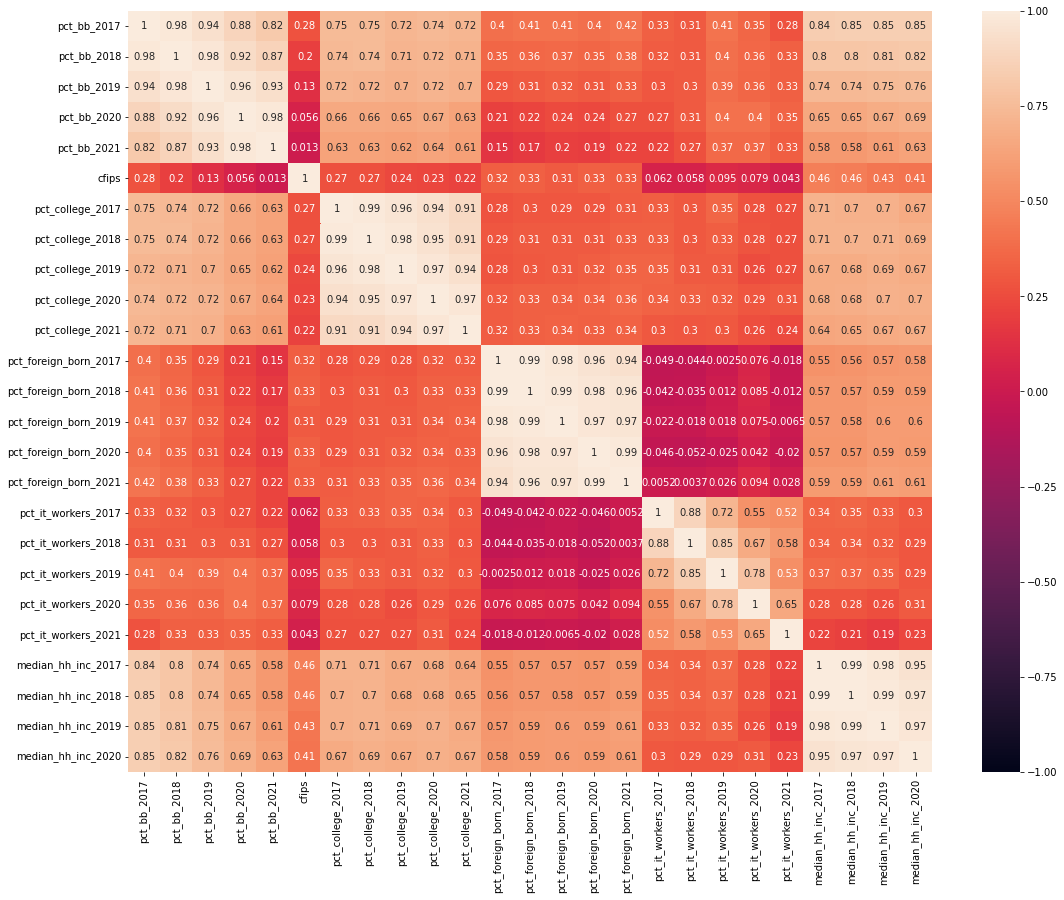

In [ ]:
plt.figure(figsize = (18,14))
sns.heatmap(census.head(100).corr(), vmax = 1, vmin = -1, annot = True)

In [ ]:
train.set_index('cfips', inplace=True)
census.set_index('cfips', inplace=True)

pre_census = train.join(census)
pre_census # 12.30 이 데이터를 확인

,row_id,first_day_of_month,microbusiness_density,active,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
cfips,,,,,,,,,,,,,,,,,,,,,
1001,1001_2019-08-01,2019-08-01,3.007682,1249,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1001,1001_2019-09-01,2019-09-01,2.884870,1198,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1001,1001_2019-10-01,2019-10-01,3.055843,1269,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1001,1001_2019-11-01,2019-11-01,2.993233,1243,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1001,1001_2019-12-01,2019-12-01,2.993233,1243,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56045,56045_2022-06-01,2022-06-01,1.803249,101,71.1,73.3,76.8,79.7,81.3,14.1,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
56045,56045_2022-07-01,2022-07-01,1.803249,101,71.1,73.3,76.8,79.7,81.3,14.1,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
56045,56045_2022-08-01,2022-08-01,1.785395,100,71.1,73.3,76.8,79.7,81.3,14.1,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0


In [ ]:
train.first_day_of_month

cfips
1001     2019-08-01
1001     2019-09-01
1001     2019-10-01
1001     2019-11-01
1001     2019-12-01
            ...    
56045    2022-06-01
56045    2022-07-01
56045    2022-08-01
56045    2022-09-01
56045    2022-10-01
Name: first_day_of_month, Length: 122265, dtype: object

In [ ]:
mask = train['first_day_of_month'].isin(['2022-10-01'])
mask

cfips
1001     False
1001     False
1001     False
1001     False
1001     False
         ...  
56045    False
56045    False
56045    False
56045    False
56045     True
Name: first_day_of_month, Length: 122265, dtype: bool

In [ ]:
train[mask] # 2022-10-01의 데이터 갯수. 3135가 안나올 경우 다시(주의)

,row_id,first_day_of_month,microbusiness_density,active
cfips,,,,
1001,1001_2022-10-01,2022-10-01,3.463856,1472
1003,1003_2022-10-01,2022-10-01,8.359798,14320
1005,1005_2022-10-01,2022-10-01,1.232074,244
1007,1007_2022-10-01,2022-10-01,1.287240,229
1009,1009_2022-10-01,2022-10-01,1.831783,813
...,...,...,...,...
56037,56037_2022-10-01,2022-10-01,2.823801,905
56039,56039_2022-10-01,2022-10-01,26.273220,5035
56041,56041_2022-10-01,2022-10-01,4.009369,582


In [ ]:
train = train[mask]
train

,row_id,first_day_of_month,microbusiness_density,active
cfips,,,,
1001,1001_2022-10-01,2022-10-01,3.463856,1472
1003,1003_2022-10-01,2022-10-01,8.359798,14320
1005,1005_2022-10-01,2022-10-01,1.232074,244
1007,1007_2022-10-01,2022-10-01,1.287240,229
1009,1009_2022-10-01,2022-10-01,1.831783,813
...,...,...,...,...
56037,56037_2022-10-01,2022-10-01,2.823801,905
56039,56039_2022-10-01,2022-10-01,26.273220,5035
56041,56041_2022-10-01,2022-10-01,4.009369,582


In [ ]:
train.sort_values(by='cfips')

,row_id,first_day_of_month,microbusiness_density,active
cfips,,,,
1001,1001_2022-10-01,2022-10-01,3.463856,1472
1003,1003_2022-10-01,2022-10-01,8.359798,14320
1005,1005_2022-10-01,2022-10-01,1.232074,244
1007,1007_2022-10-01,2022-10-01,1.287240,229
1009,1009_2022-10-01,2022-10-01,1.831783,813
...,...,...,...,...
56037,56037_2022-10-01,2022-10-01,2.823801,905
56039,56039_2022-10-01,2022-10-01,26.273220,5035
56041,56041_2022-10-01,2022-10-01,4.009369,582


In [ ]:
census.sort_values(by='cfips')

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
cfips,,,,,,,,,,,,,,,,,,,,,
1001,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1003,74.5,78.1,81.8,85.1,87.9,20.4,20.7,21.0,20.2,20.6,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
1005,57.2,60.4,60.5,64.6,64.6,7.6,7.8,7.6,7.3,6.7,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
1007,62.0,66.1,69.2,76.1,74.6,8.1,7.6,6.5,7.4,7.9,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
1009,65.8,68.5,73.0,79.6,81.0,8.7,8.1,8.6,8.9,9.3,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,82.2,82.4,84.0,86.7,88.4,15.3,15.2,14.8,13.7,12.4,...,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0
56039,83.5,85.9,87.1,89.1,90.5,37.7,37.8,38.9,37.2,38.3,...,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0
56041,83.8,88.2,89.5,91.4,90.6,11.9,10.5,11.1,12.6,12.3,...,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0


In [ ]:
col1=census.columns[5:].to_list()
col2=census.columns[:5].to_list()
new_col=col1+col2
census=census[new_col]
census

,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,...,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021
cfips,,,,,,,,,,,,,,,,,,,,,
1001,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,...,55317,58786.0,58731,57982.0,62660.0,76.6,78.9,80.6,82.7,85.5
1003,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,...,52562,55962.0,58320,61756.0,64346.0,74.5,78.1,81.8,85.1,87.9
1005,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,...,33368,34186.0,32525,34990.0,36422.0,57.2,60.4,60.5,64.6,64.6
1007,8.1,7.6,6.5,7.4,7.9,1.0,1.4,1.5,1.6,1.1,...,43404,45340.0,47542,51721.0,54277.0,62.0,66.1,69.2,76.1,74.6
1009,8.7,8.1,8.6,8.9,9.3,4.5,4.4,4.5,4.4,4.5,...,47412,48695.0,49358,48922.0,52830.0,65.8,68.5,73.0,79.6,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,15.3,15.2,14.8,13.7,12.4,5.0,5.3,4.7,5.2,5.5,...,71083,73008.0,74843,73384.0,76668.0,82.2,82.4,84.0,86.7,88.4
56039,37.7,37.8,38.9,37.2,38.3,10.8,11.2,11.8,11.4,11.1,...,80049,83831.0,84678,87053.0,94498.0,83.5,85.9,87.1,89.1,90.5
56041,11.9,10.5,11.1,12.6,12.3,2.9,3.1,2.9,2.9,2.9,...,54672,58235.0,63403,72458.0,75106.0,83.8,88.2,89.5,91.4,90.6


In [ ]:
census.columns

Index(['pct_college_2017', 'pct_college_2018', 'pct_college_2019',
       'pct_college_2020', 'pct_college_2021', 'pct_foreign_born_2017',
       'pct_foreign_born_2018', 'pct_foreign_born_2019',
       'pct_foreign_born_2020', 'pct_foreign_born_2021', 'pct_it_workers_2017',
       'pct_it_workers_2018', 'pct_it_workers_2019', 'pct_it_workers_2020',
       'pct_it_workers_2021', 'median_hh_inc_2017', 'median_hh_inc_2018',
       'median_hh_inc_2019', 'median_hh_inc_2020', 'median_hh_inc_2021',
       'pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021'],
      dtype='object')

In [ ]:
col1=train.columns[2:].to_list()
col2=train.columns[:2].to_list()
new_col=col1+col2
train=train[new_col]
train

,microbusiness_density,active,row_id,first_day_of_month
cfips,,,,
1001,3.463856,1472,1001_2022-10-01,2022-10-01
1003,8.359798,14320,1003_2022-10-01,2022-10-01
1005,1.232074,244,1005_2022-10-01,2022-10-01
1007,1.287240,229,1007_2022-10-01,2022-10-01
1009,1.831783,813,1009_2022-10-01,2022-10-01
...,...,...,...,...
56037,2.823801,905,56037_2022-10-01,2022-10-01
56039,26.273220,5035,56039_2022-10-01,2022-10-01
56041,4.009369,582,56041_2022-10-01,2022-10-01


In [ ]:
train2 = train.copy()#복사
train2

,microbusiness_density,active,row_id,first_day_of_month
cfips,,,,
1001,3.463856,1472.0,1001_2022-10-01,2022-10-01
1003,8.359798,14320.0,1003_2022-10-01,2022-10-01
1005,1.232074,244.0,1005_2022-10-01,2022-10-01
1007,1.287240,229.0,1007_2022-10-01,2022-10-01
1009,1.831783,813.0,1009_2022-10-01,2022-10-01
...,...,...,...,...
22047,1.443180,374.0,22047_2022-10-01,2022-10-01
22049,0.982428,123.0,22049_2022-10-01,2022-10-01
22051,5.208730,17649.0,22051_2022-10-01,2022-10-01


In [ ]:
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"]) # first_day_of_month 날짜형 데이터로 처리

In [ ]:
new_train = train.iloc[:,:5].sort_values(by='cfips')
new_train

,microbusiness_density,active,row_id,first_day_of_month
cfips,,,,
1001,3.463856,1472,1001_2022-10-01,2022-10-01
1003,8.359798,14320,1003_2022-10-01,2022-10-01
1005,1.232074,244,1005_2022-10-01,2022-10-01
1007,1.287240,229,1007_2022-10-01,2022-10-01
1009,1.831783,813,1009_2022-10-01,2022-10-01
...,...,...,...,...
56037,2.823801,905,56037_2022-10-01,2022-10-01
56039,26.273220,5035,56039_2022-10-01,2022-10-01
56041,4.009369,582,56041_2022-10-01,2022-10-01


In [ ]:
census

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
cfips,,,,,,,,,,,,,,,,,,,,,
1001,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1003,74.5,78.1,81.8,85.1,87.9,20.4,20.7,21.0,20.2,20.6,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
1005,57.2,60.4,60.5,64.6,64.6,7.6,7.8,7.6,7.3,6.7,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
1007,62.0,66.1,69.2,76.1,74.6,8.1,7.6,6.5,7.4,7.9,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
1009,65.8,68.5,73.0,79.6,81.0,8.7,8.1,8.6,8.9,9.3,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,82.2,82.4,84.0,86.7,88.4,15.3,15.2,14.8,13.7,12.4,...,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0
56039,83.5,85.9,87.1,89.1,90.5,37.7,37.8,38.9,37.2,38.3,...,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0
56041,83.8,88.2,89.5,91.4,90.6,11.9,10.5,11.1,12.6,12.3,...,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0


In [ ]:
the_new_train = pd.merge(new_train, census, left_index=True, right_index=True, how='left') #1 조합 성공

In [ ]:
the_new_train

,microbusiness_density,active,row_id,first_day_of_month,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
cfips,,,,,,,,,,,,,,,,,,,,,
1001,3.463856,1472,1001_2022-10-01,2022-10-01,76.6,78.9,80.6,82.7,85.5,14.5,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1003,8.359798,14320,1003_2022-10-01,2022-10-01,74.5,78.1,81.8,85.1,87.9,20.4,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
1005,1.232074,244,1005_2022-10-01,2022-10-01,57.2,60.4,60.5,64.6,64.6,7.6,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
1007,1.287240,229,1007_2022-10-01,2022-10-01,62.0,66.1,69.2,76.1,74.6,8.1,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
1009,1.831783,813,1009_2022-10-01,2022-10-01,65.8,68.5,73.0,79.6,81.0,8.7,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,2.823801,905,56037_2022-10-01,2022-10-01,82.2,82.4,84.0,86.7,88.4,15.3,...,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0
56039,26.273220,5035,56039_2022-10-01,2022-10-01,83.5,85.9,87.1,89.1,90.5,37.7,...,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0
56041,4.009369,582,56041_2022-10-01,2022-10-01,83.8,88.2,89.5,91.4,90.6,11.9,...,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0


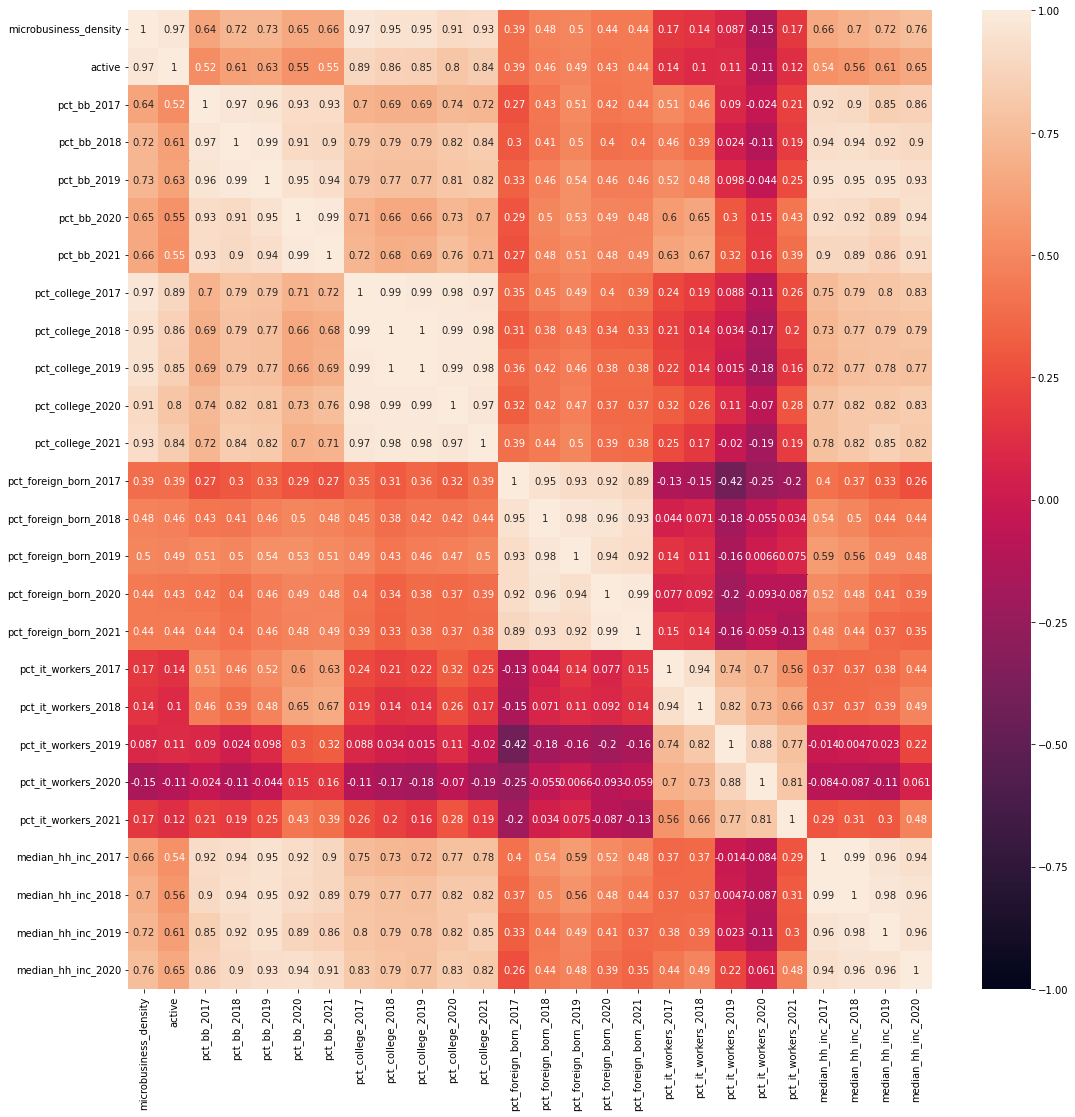

In [ ]:
plt.figure(figsize = (18,18))
sns.heatmap(the_new_train.head(10).corr(), vmax = 1, vmin = -1, annot = True)

In [ ]:
# cfips 를 기준으로 나머지는 추후 test에서 데이터 전처리

In [ ]:
the_new_train.info() # object발견. 2021의 가계소득 중앙값
# the_new_train.median_hh_inc_2021.dtype
the_new_train['median_hh_inc_2021']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3135 entries, 1001 to 56045
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   microbusiness_density  3135 non-null   float64       
 1   active                 3135 non-null   int64         
 2   row_id                 3135 non-null   object        
 3   first_day_of_month     3135 non-null   datetime64[ns]
 4   pct_bb_2017            3135 non-null   float64       
 5   pct_bb_2018            3135 non-null   float64       
 6   pct_bb_2019            3135 non-null   float64       
 7   pct_bb_2020            3135 non-null   float64       
 8   pct_bb_2021            3135 non-null   float64       
 9   pct_college_2017       3135 non-null   float64       
 10  pct_college_2018       3135 non-null   float64       
 11  pct_college_2019       3135 non-null   float64       
 12  pct_college_2020       3135 non-null   float64       
 13 

cfips
1001     62660.0
1003     64346.0
1005     36422.0
1007     54277.0
1009     52830.0
          ...   
56037    76668.0
56039    94498.0
56041    75106.0
56043    62271.0
56045    65566.0
Name: median_hh_inc_2021, Length: 3135, dtype: object

In [ ]:
the_new_train.isnull().sum() # 결측치는 없습니다

In [ ]:
the_new_train = the_new_train.astype({"median_hh_inc_2021":"int"})
t = the_new_train.iloc[:,23:24]
# the_new_train['median_hh_inc2021'] = the_new_train['median_hh_inc_2021']
# the_new_train.info() # median_hh_inc_2021는 어째서인지 object에서 변경이 안됨. 
# 직접 보기에는 숫자들인데, method로 확인됨
#더미데이터로 제작은 열이 3000개로 늘어나서 불가

In [ ]:
# 열 삭제
# 주의
the_new_train.drop('median_hh_inc_2021', axis = 1, inplace = True)

In [ ]:
the_new_train.isnull().sum()

microbusiness_density    0
active                   0
row_id                   0
first_day_of_month       0
pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              0
pct_bb_2021              0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         0
pct_college_2021         0
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    0
pct_foreign_born_2021    0
pct_it_workers_2017      0
pct_it_workers_2018      0
pct_it_workers_2019      0
pct_it_workers_2020      0
pct_it_workers_2021      0
median_hh_inc_2017       0
median_hh_inc_2018       0
median_hh_inc_2019       0
median_hh_inc_2020       0
dtype: int64

In [ ]:
the_new_train.info() # 데이터 전처리 완료

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3135 entries, 1001 to 56045
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   microbusiness_density  3135 non-null   float64       
 1   active                 3135 non-null   int64         
 2   row_id                 3135 non-null   object        
 3   first_day_of_month     3135 non-null   datetime64[ns]
 4   pct_bb_2017            3135 non-null   float64       
 5   pct_bb_2018            3135 non-null   float64       
 6   pct_bb_2019            3135 non-null   float64       
 7   pct_bb_2020            3135 non-null   float64       
 8   pct_bb_2021            3135 non-null   float64       
 9   pct_college_2017       3135 non-null   float64       
 10  pct_college_2018       3135 non-null   float64       
 11  pct_college_2019       3135 non-null   float64       
 12  pct_college_2020       3135 non-null   float64       
 13 

In [ ]:
# row_id drop한 버전

the_new_train.drop('row_id', axis = 1, inplace = True)

In [ ]:
# 훈련셋 분리 후 스케일링 →학습 → 시작
X = the_new_train.drop(['microbusiness_density', 'first_day_of_month'], axis = 1)
y = the_new_train['microbusiness_density']

In [ ]:
# 분리. 날짜 제외

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [ ]:
X # 확인

,active,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020
cfips,,,,,,,,,,,,,,,,,,,,,
1001,1472,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,...,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0
1003,14320,74.5,78.1,81.8,85.1,87.9,20.4,20.7,21.0,20.2,...,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0
1005,244,57.2,60.4,60.5,64.6,64.6,7.6,7.8,7.6,7.3,...,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0
1007,229,62.0,66.1,69.2,76.1,74.6,8.1,7.6,6.5,7.4,...,1.1,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0
1009,813,65.8,68.5,73.0,79.6,81.0,8.7,8.1,8.6,8.9,...,4.5,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,905,82.2,82.4,84.0,86.7,88.4,15.3,15.2,14.8,13.7,...,5.5,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0
56039,5035,83.5,85.9,87.1,89.1,90.5,37.7,37.8,38.9,37.2,...,11.1,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0
56041,582,83.8,88.2,89.5,91.4,90.6,11.9,10.5,11.1,12.6,...,2.9,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0


In [ ]:
X.columns

Index(['active', 'pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020'],
      dtype='object')

In [ ]:
scale = StandardScaler() # 에러 위험을 낮추기 위해 고려
X_trainst = scale.fit_transform(X_train)
X_testst = scale.transform(X_test)

In [ ]:
model = LinearRegression()
model.fit(X_trainst, y_train)

LinearRegression()

In [ ]:
pred = model.predict(X_testst)
pred

array([ 3.40700591e+00,  7.67420291e+00,  1.89615097e+00,  2.22877226e+00,
        1.22798787e+00,  1.25600346e+01,  1.89742181e-01,  8.61130631e+00,
        2.86450021e+00,  5.75838388e+00,  2.21460055e+00,  2.46220865e+00,
        4.45695350e+00,  4.68982626e+00,  6.44832686e+00,  1.00625312e+01,
        2.41092299e+00,  7.19244192e+00,  2.19007296e+00,  2.96827036e+00,
        2.60003011e+00,  2.34087546e+00,  3.21604559e+00,  5.06977977e+00,
        7.37477148e+00,  4.01813911e+00,  1.04242833e+01,  5.40319438e+00,
        4.43856429e+00,  3.29042568e+00,  9.84025469e+00,  6.49227743e-01,
        3.81516159e+00,  3.27152379e+00,  4.70368621e+00,  6.77328735e+00,
        7.28694597e+00,  1.89311241e+00,  5.55172697e-03,  3.99679351e+00,
        5.74272798e+00,  4.75688469e+00,  6.23780840e+00,  2.82326253e+00,
        2.37673809e+00,  5.07515034e+00,  8.33583818e+00,  5.65257394e+00,
        4.03798465e+00,  3.11324568e+00,  4.12125490e+00,  4.91040794e+00,
        1.72620206e+00,  

In [ ]:
# 테이블로 평가
comparison = pd.DataFrame({
    'actual': y_test, # 실제값
    'pred': pred
}) 
comparison

,actual,pred
cfips,,
8043,3.623784,3.407006
53013,2.580258,7.674203
51017,2.736318,1.896151
26157,2.078809,2.228772
26119,2.754960,1.227988
...,...,...
26127,2.666148,2.870470
55095,4.640566,3.946307
37109,5.263868,4.783580


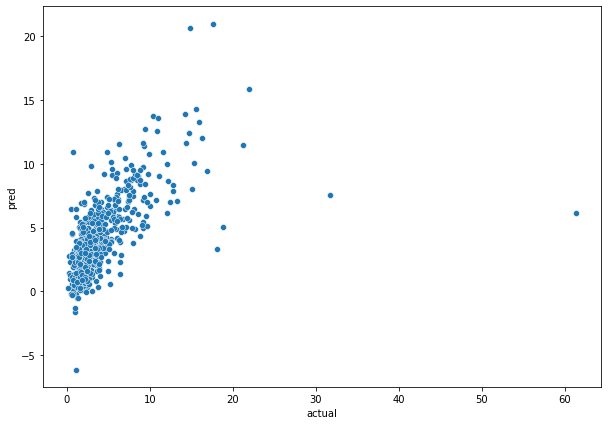

In [ ]:
# scatterplot 제작
plt.figure(figsize=(10, 7))
sns.scatterplot(x = 'actual', y= 'pred', data = comparison)
plt.show() # 1,2개의 아웃라이어

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# mse 평가
mean_squared_error(y_test, pred)

10.444502825135869

In [ ]:
# rmse 평가
mean_squared_error(y_test, pred, squared=False)

3.2317956038610904

In [ ]:
# mae 평가

mean_absolute_error(y_test, pred)

1.6267654123898434

In [ ]:
model.score(X_trainst, y_train) # R²
# 매우 낮은 결정계수

0.19693808002268087

In [ ]:
model.coef_ # 기울기 계산치

array([ 0.90986398,  0.71728452,  0.53207748, -0.5230034 , -1.2052083 ,
        0.91274613,  2.76083688, -2.05256119,  0.7255758 , -0.88924512,
        1.48274368,  0.59208773,  1.26570724, -3.41667796,  3.49990337,
       -1.73861786, -0.08794189,  0.56233963, -0.95198716,  0.97016436,
       -0.17674202, -1.57260643,  0.70700137,  0.01845337,  0.59432548])

# KNN 모델

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_trainst, y_train)
pred = knn.predict(X_testst)

In [ ]:
pred # 예측치

array([ 2.91282222,  4.31503534,  2.4685733 ,  1.99003472,  2.01334639,
       11.16546798,  1.21805003,  9.09972294,  3.1937901 ,  5.09158284,
        2.31247748,  2.08689566,  3.36259396,  1.93502131,  5.33054378,
        8.31882668,  2.92005334,  4.30703968,  1.5084101 ,  3.2279087 ,
        1.97164058,  2.03158456,  2.08556718,  5.92620602,  4.91651118,
        4.57195546, 10.59191022,  3.89271068,  4.27466634,  2.85412252,
        6.7256194 ,  1.30843704,  3.40399924,  2.05893672,  4.35945974,
       14.171902  ,  5.65208344,  1.1950526 ,  2.3148558 ,  3.73603916,
        3.55359968,  5.31590356,  4.12567234,  1.45544504,  2.50985186,
        3.02025228, 11.27495516,  3.8384132 ,  3.06038218,  2.92715814,
        2.7837291 ,  4.51712934,  1.8549631 ,  2.34670118,  2.20218252,
        2.68117916,  2.53481704,  1.94985941,  1.96392248,  3.2918396 ,
        7.96123846,  2.78532366,  9.2015199 ,  5.21776334,  2.73464708,
        2.24250818,  1.52941879,  4.36244488, 10.1407506 ,  5.69

In [ ]:
# 테이블로 평가
comparison = pd.DataFrame({
    'actual': y_test, # 실제값
    'pred': pred
}) 
comparison

,actual,pred
cfips,,
8043,3.623784,2.912822
53013,2.580258,4.315035
51017,2.736318,2.468573
26157,2.078809,1.990035
26119,2.754960,2.013346
...,...,...
26127,2.666148,2.414729
55095,4.640566,2.595317
37109,5.263868,3.057723


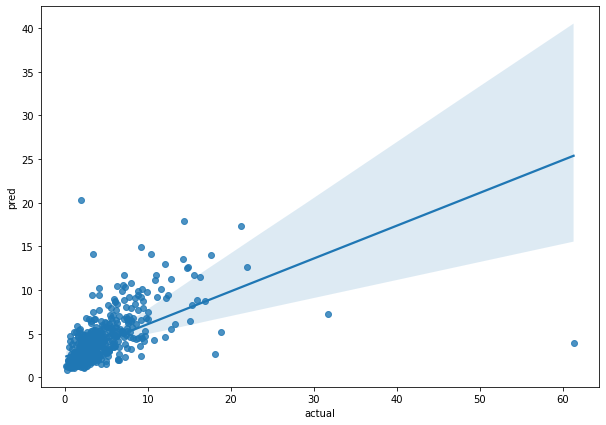

In [ ]:
# regplot 제작
plt.figure(figsize=(10, 7))
sns.regplot(x = 'actual', y= 'pred', data = comparison)
plt.show()

In [ ]:
# mse 평가
mean_squared_error(y_test, pred) # 에러가 더 늘어남

11.200077812576886

In [ ]:
# rmse 평가
mean_squared_error(y_test, pred, squared=False)

3.3466517315933677

In [ ]:
# mae 평가

mean_absolute_error(y_test, pred)

1.5145651904976076

In [ ]:
model.score(X_trainst, y_train) # R^2

0.19693808002268087

# LightGBM 시도

In [ ]:
# # 사용할 params정의
params = {"n_estimators" : [100, 500, 1000],"learning_rate" : [0.01, 0.05, 0.1, 0.3]
          ,"lambda_l1" : [0, 10, 20],"lambda_l2" : [0, 10, 20],"max_depth" : [5, 10, 15, 20],"subsample": [0.6, 0.8, 1]}

In [ ]:
# LigthGBM 사용

model = lgb.LGBMRegressor(random_state = 100)

# 하이퍼패러미터 튜닝?
# 랜덤서치cv 사용 - n_iter와 scoring 따로 정의
# new_train_model = RandomizedSearchCV(model,
#       param_distributions = params, 
#       n_iter = 10, scoring = 'roc_auc', 
#       random_state=100, n_jobs = -1)

# 랜덤서치cv 사용 - n_iter와 scoring :기본 세팅만 하고 cv를 정의
new_train_model = RandomizedSearchCV(model,
      param_distributions = params, 
      cv = 20,
      random_state=100, n_jobs = -1)

In [ ]:
new_train_model

RandomizedSearchCV(cv=20, estimator=LGBMRegressor(random_state=100), n_jobs=-1,
                   param_distributions={'lambda_l1': [0, 10, 20],
                                        'lambda_l2': [0, 10, 20],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1]},
                   random_state=100)

In [ ]:
new_train_model.fit(X_trainst, y_train) # 시간 소요 체크
# 3분 42초 소요
# 두번째 학습 1분 38초 소요 why?

RandomizedSearchCV(cv=20, estimator=LGBMRegressor(random_state=100), n_jobs=-1,
                   param_distributions={'lambda_l1': [0, 10, 20],
                                        'lambda_l2': [0, 10, 20],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1]},
                   random_state=100)

In [ ]:
new_train_model.best_params_ # 최적의 패러미터를 계산

{'subsample': 1,
 'n_estimators': 500,
 'max_depth': 20,
 'learning_rate': 0.01,
 'lambda_l2': 20,
 'lambda_l1': 10}

In [ ]:
new_train_model.best_score_ # 최적의 점수계산 cv3일때 0.338
# cv 9일때 0.376

0.4703737277864305

In [ ]:
# CV의 result
new_train_model.cv_results_

In [ ]:
# CV의 result - DF 추가
cv_result = pd.DataFrame(new_train_model.cv_results_)
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,param_lambda_l2,param_lambda_l1,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
0,0.266052,0.014386,0.002444,0.001019,0.6,100,5,0.1,20,10,...,0.490770,0.106948,0.419517,0.588315,0.236375,0.462660,0.548526,0.432991,0.205691,3
1,2.272556,0.042817,0.010343,0.000673,0.8,1000,5,0.1,0,0,...,-0.076471,0.088929,0.110960,0.649148,-0.581066,0.254144,0.447019,0.131377,0.353850,10
2,6.318491,0.329802,0.023783,0.006204,1,1000,15,0.05,20,0,...,-0.154514,0.086348,0.190020,0.589694,-0.347875,0.261921,0.518303,0.214245,0.295471,8
3,5.188106,0.154617,0.022381,0.004920,1,1000,10,0.05,0,0,...,-0.229281,0.103605,0.219803,0.584426,-0.632805,0.306700,0.473032,0.156171,0.334257,9
4,0.534748,0.017174,0.002647,0.000141,0.8,100,10,0.1,20,10,...,0.401093,0.089524,0.428950,0.566326,0.230971,0.462251,0.584574,0.427451,0.208975,4
5,0.299697,0.012209,0.001965,0.000146,0.8,100,5,0.01,10,20,...,0.555212,0.047119,0.384926,0.294477,0.430416,0.442348,0.408533,0.410709,0.189989,5
6,2.628080,0.030357,0.008058,0.001267,1,500,20,0.01,20,10,...,0.547887,0.086313,0.467218,0.529155,0.404413,0.499346,0.567885,0.470374,0.206023,1
7,0.630169,0.013963,0.002682,0.000071,0.8,100,20,0.3,10,0,...,-0.212352,0.114467,0.156510,0.622522,-0.203329,0.253064,0.513945,0.228273,0.246986,7
8,0.495398,0.009945,0.002716,0.000108,0.8,100,20,0.1,20,20,...,0.460611,0.095460,0.390448,0.578925,0.230291,0.486514,0.557130,0.437067,0.212024,2
9,2.428426,0.441139,0.008939,0.000627,0.6,500,10,0.05,0,20,...,0.130622,0.075193,0.103547,0.623270,-0.174781,0.373714,0.473236,0.289442,0.267196,6


In [ ]:
cv_result = cv_result.sort_values('rank_test_score')
cv_result
# pd.DataFrame(new_train_model.cv_results_).columns

,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,param_lambda_l2,...,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score
6,1,2.628080,0.030357,0.008058,0.001267,1,500,20,0.01,20,...,0.690832,0.547887,0.086313,0.467218,0.529155,0.404413,0.499346,0.567885,0.470374,0.206023
8,2,0.495398,0.009945,0.002716,0.000108,0.8,100,20,0.1,20,...,0.689765,0.460611,0.095460,0.390448,0.578925,0.230291,0.486514,0.557130,0.437067,0.212024
0,3,0.266052,0.014386,0.002444,0.001019,0.6,100,5,0.1,20,...,0.710720,0.490770,0.106948,0.419517,0.588315,0.236375,0.462660,0.548526,0.432991,0.205691
4,4,0.534748,0.017174,0.002647,0.000141,0.8,100,10,0.1,20,...,0.709624,0.401093,0.089524,0.428950,0.566326,0.230971,0.462251,0.584574,0.427451,0.208975
5,5,0.299697,0.012209,0.001965,0.000146,0.8,100,5,0.01,10,...,0.524051,0.555212,0.047119,0.384926,0.294477,0.430416,0.442348,0.408533,0.410709,0.189989
9,6,2.428426,0.441139,0.008939,0.000627,0.6,500,10,0.05,0,...,0.664307,0.130622,0.075193,0.103547,0.623270,-0.174781,0.373714,0.473236,0.289442,0.267196
7,7,0.630169,0.013963,0.002682,0.000071,0.8,100,20,0.3,10,...,0.630210,-0.212352,0.114467,0.156510,0.622522,-0.203329,0.253064,0.513945,0.228273,0.246986
2,8,6.318491,0.329802,0.023783,0.006204,1,1000,15,0.05,20,...,0.705000,-0.154514,0.086348,0.190020,0.589694,-0.347875,0.261921,0.518303,0.214245,0.295471
3,9,5.188106,0.154617,0.022381,0.004920,1,1000,10,0.05,0,...,0.638077,-0.229281,0.103605,0.219803,0.584426,-0.632805,0.306700,0.473032,0.156171,0.334257
1,10,2.272556,0.042817,0.010343,0.000673,0.8,1000,5,0.1,0,...,0.600142,-0.076471,0.088929,0.110960,0.649148,-0.581066,0.254144,0.447019,0.131377,0.353850


In [ ]:
col1=cv_result.columns[33:].to_list()
col2=cv_result.columns[:33].to_list()
new_col=col1+col2
cv_result=cv_result[new_col]
cv_result

,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,param_lambda_l2,...,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score
0,3,0.266052,0.014386,0.002444,0.001019,0.6,100,5,0.1,20,...,0.710720,0.490770,0.106948,0.419517,0.588315,0.236375,0.462660,0.548526,0.432991,0.205691
1,10,2.272556,0.042817,0.010343,0.000673,0.8,1000,5,0.1,0,...,0.600142,-0.076471,0.088929,0.110960,0.649148,-0.581066,0.254144,0.447019,0.131377,0.353850
2,8,6.318491,0.329802,0.023783,0.006204,1,1000,15,0.05,20,...,0.705000,-0.154514,0.086348,0.190020,0.589694,-0.347875,0.261921,0.518303,0.214245,0.295471
3,9,5.188106,0.154617,0.022381,0.004920,1,1000,10,0.05,0,...,0.638077,-0.229281,0.103605,0.219803,0.584426,-0.632805,0.306700,0.473032,0.156171,0.334257
4,4,0.534748,0.017174,0.002647,0.000141,0.8,100,10,0.1,20,...,0.709624,0.401093,0.089524,0.428950,0.566326,0.230971,0.462251,0.584574,0.427451,0.208975
5,5,0.299697,0.012209,0.001965,0.000146,0.8,100,5,0.01,10,...,0.524051,0.555212,0.047119,0.384926,0.294477,0.430416,0.442348,0.408533,0.410709,0.189989
6,1,2.628080,0.030357,0.008058,0.001267,1,500,20,0.01,20,...,0.690832,0.547887,0.086313,0.467218,0.529155,0.404413,0.499346,0.567885,0.470374,0.206023
7,7,0.630169,0.013963,0.002682,0.000071,0.8,100,20,0.3,10,...,0.630210,-0.212352,0.114467,0.156510,0.622522,-0.203329,0.253064,0.513945,0.228273,0.246986
8,2,0.495398,0.009945,0.002716,0.000108,0.8,100,20,0.1,20,...,0.689765,0.460611,0.095460,0.390448,0.578925,0.230291,0.486514,0.557130,0.437067,0.212024
9,6,2.428426,0.441139,0.008939,0.000627,0.6,500,10,0.05,0,...,0.664307,0.130622,0.075193,0.103547,0.623270,-0.174781,0.373714,0.473236,0.289442,0.267196
